# **A/B Testing**

When analyzing the results of an A/B test (where you compare two versions of a product or design), you're required to ensure that the new design (let's call it "Version B") improves the completion rate by at least 5% compared to the current version (Version A).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
test_df = pd.read_csv('../../data/clean/test_variation_df_clean.csv')
control_df = pd.read_csv('../../data/clean/control_variation_df_clean.csv')  

In [3]:
# Step 1: Remove duplicates and fix completion_count if necessary
test_df_cleaned = test_df.drop_duplicates(subset=['client_id', 'visitor_id'])
control_df_cleaned = control_df.drop_duplicates(subset=['client_id', 'visitor_id'])

# Ensure completion_count is binary (0 or 1) using .loc for safe assignment
test_df_cleaned.loc[:, 'completion_count'] = test_df_cleaned['completion_count'].apply(lambda x: 1 if x > 0 else 0)
control_df_cleaned.loc[:, 'completion_count'] = control_df_cleaned['completion_count'].apply(lambda x: 1 if x > 0 else 0)

# Step 2: Calculate completions and sample size
test_completions = test_df_cleaned['completion_count'].sum()
control_completions = control_df_cleaned['completion_count'].sum()

test_size = len(test_df_cleaned)
control_size = len(control_df_cleaned)

# Step 3: Calculate completion rates
test_completion_rate = test_completions / test_size
control_completion_rate = control_completions / control_size

print(f"Test Group Completion Rate: {test_completion_rate * 100:.2f}%")
print(f"Control Group Completion Rate: {control_completion_rate * 100:.2f}%")

# Step 4: Check if the completion rates are valid (i.e., between 0 and 1)
if test_completion_rate == 0 or test_completion_rate == 1 or control_completion_rate == 0 or control_completion_rate == 1:
    print("One of the groups has a completion rate of 0 or 1, skipping Z-test.")
else:
    # Step 5: Perform Z-test for proportions
    p_pooled = (test_completions + control_completions) / (test_size + control_size)
    try:
        se = np.sqrt(p_pooled * (1 - p_pooled) * (1 / test_size + 1 / control_size))
    except ValueError as e:
        print(f"Error in standard error calculation: {e}")
        se = None

    if se is not None:
        z = (test_completion_rate - control_completion_rate) / se
        p_value = 2 * (1 - norm.cdf(abs(z)))

        print(f"Z-score: {z:.2f}")
        print(f"P-value: {p_value:.4f}")

        # Step 6: Check if the result is significant
        alpha = 0.05  # 95% confidence level

        if p_value < alpha:
            print("The difference between the groups is statistically significant.")
        else:
            print("The difference between the groups is not statistically significant.")
    else:
        print("Skipping statistical test due to invalid data.")

Test Group Completion Rate: 69.77%
Control Group Completion Rate: 65.90%
Z-score: 9.82
P-value: 0.0000
The difference between the groups is statistically significant.


# Plots

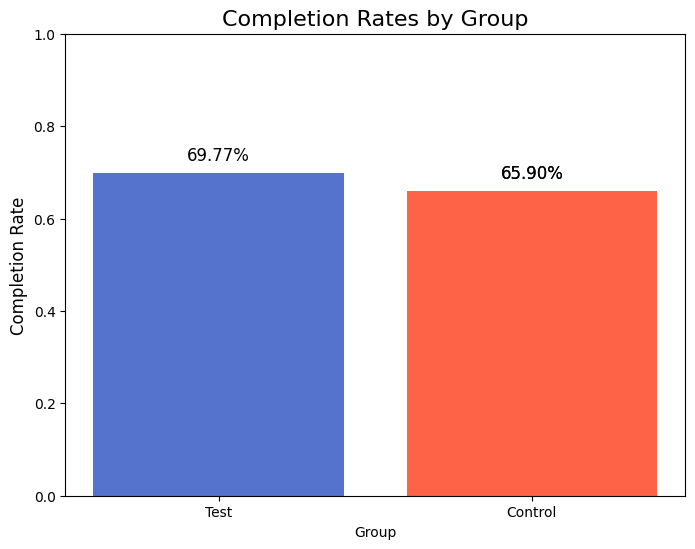

In [4]:
completion_data = pd.DataFrame({
    'Group': ['Test', 'Control'],
    'Completion Rate': [test_completion_rate, control_completion_rate]
})

# Define custom colors
test_color = 'royalblue'
control_color = 'tomato'

plt.figure(figsize=(8, 6))
ax = sns.barplot(x='Group', y='Completion Rate', data=completion_data, color=test_color)

plt.bar(1, control_completion_rate, color=control_color)

# Add percentages on top of each bar
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height * 100:.2f}%', 
            ha='center', va='bottom', fontsize=12, color='black')

plt.title('Completion Rates by Group', fontsize=16)
plt.ylabel('Completion Rate', fontsize=12)
plt.ylim(0, 1)  # Completion rate should be between 0 and 1

plt.show()

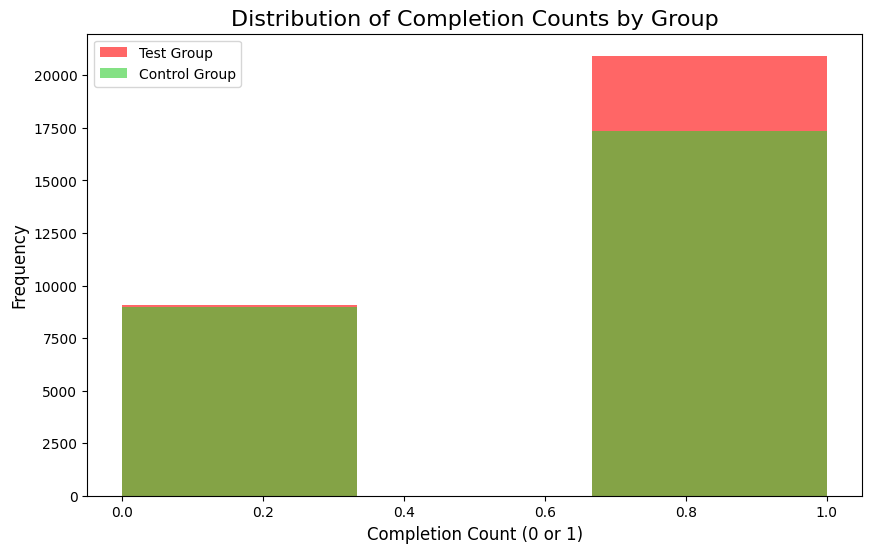

In [5]:
# **Histograms of Completion Counts (Test vs Control)**

# Plot histograms to visualize the distribution of completion counts
plt.figure(figsize=(10, 6))
sns.histplot(test_df_cleaned['completion_count'], kde=False, color='red', label='Test Group', bins=3, alpha=0.6, edgecolor='none')
sns.histplot(control_df_cleaned['completion_count'], kde=False, color='limegreen', label='Control Group', bins=3, alpha=0.6, edgecolor='none')
plt.title('Distribution of Completion Counts by Group', fontsize=16)
plt.xlabel('Completion Count (0 or 1)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend()
plt.show()

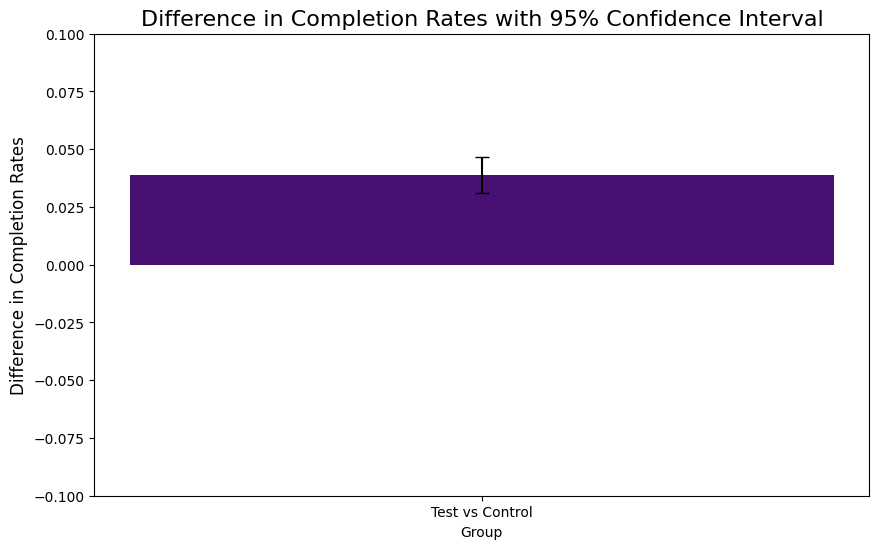

In [6]:
# Calculate the margin for the 95% confidence interval
confidence_interval_margin = 1.96 * np.sqrt((test_completion_rate * (1 - test_completion_rate) / test_size) + 
                                            (control_completion_rate * (1 - control_completion_rate) / control_size))

# Create a DataFrame for plotting CI
ci_data = pd.DataFrame({
    'Group': ['Test vs Control'],
    'Difference': [test_completion_rate - control_completion_rate],
    'CI_Lower': [test_completion_rate - control_completion_rate - confidence_interval_margin],
    'CI_Upper': [test_completion_rate - control_completion_rate + confidence_interval_margin]
})

plt.figure(figsize=(10, 6))

sns.barplot(x='Group', y='Difference', data=ci_data, color='indigo', errorbar=None)

yerr = np.array([ci_data['Difference'] - ci_data['CI_Lower'], ci_data['CI_Upper'] - ci_data['Difference']])

# Use error bars to show the 95% CI
plt.errorbar(x=[0], y=ci_data['Difference'], yerr=yerr, fmt='none', color='black', capsize=5)

plt.title('Difference in Completion Rates with 95% Confidence Interval', fontsize=16)
plt.ylabel('Difference in Completion Rates', fontsize=12)
plt.ylim(-0.1, 0.1)  # To visualize the small differences

plt.show()

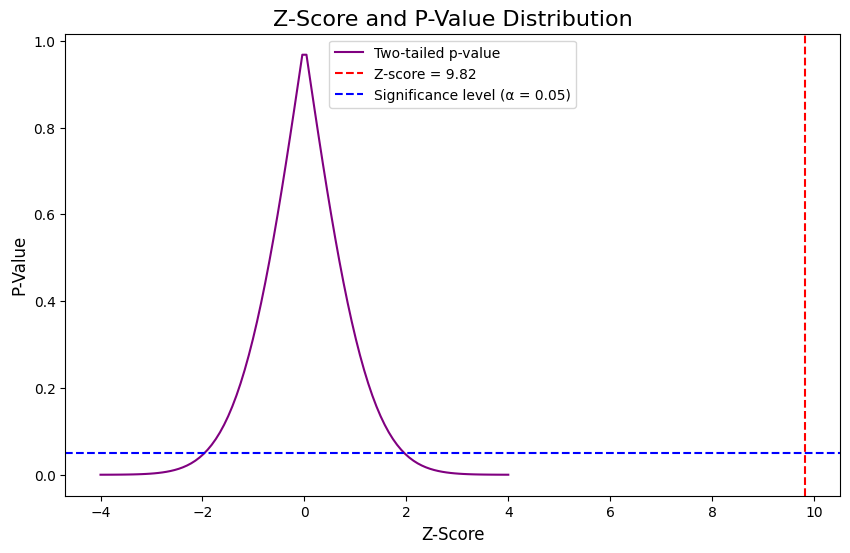

In [7]:
# ** Z-Score Plot (Visualizing Statistical Significance)**

if se is not None:
    plt.figure(figsize=(10, 6))
    z_scores = np.linspace(-4, 4, 100)
    p_values = 2 * (1 - norm.cdf(np.abs(z_scores)))

    # Plot the Z-score distribution curve
    plt.plot(z_scores, p_values, label='Two-tailed p-value', color='purple')
    plt.axvline(x=z, color='red', linestyle='--', label=f'Z-score = {z:.2f}')

    # Display the p-value threshold (alpha = 0.05)
    plt.axhline(y=0.05, color='blue', linestyle='--', label='Significance level (α = 0.05)')

    plt.title('Z-Score and P-Value Distribution', fontsize=16)
    plt.xlabel('Z-Score', fontsize=12)
    plt.ylabel('P-Value', fontsize=12)
    plt.legend()
    plt.show()

else:
    print("Skipping Z-score plot due to invalid data.")

### **Conclusions**

Based on the analysis results, the following conclusions can be drawn:

#### Completion Rate Comparison:  
- **Test Group Completion Rate:** 69.77%  
- **Control Group Completion Rate:** 65.90%  

The **test group** (with the new design) has a higher completion rate than the **control group**, suggesting that the new design is more effective at driving user completions.

#### Statistical Significance:  
- **Z-score:** 9.82  
- **P-value:** 0.0000  

A high **Z-score** of 9.82 indicates a significant difference between the two groups. The **P-value** of 0.0000 is much smaller than 0.05, confirming that the observed difference is statistically significant.

#### Hypothesis Conclusion:  
- The **null hypothesis** (no difference between groups) is **rejected**.  
- The **alternative hypothesis** (test group performs better) is **accepted**.

#### Practical Implications:  
The new design (test group) is more effective at driving user completions than the old design (control group). The large **Z-score** further indicates that this result is not due to random chance.

#### Confidence Interval for the Difference:  
The 95% confidence interval for the difference does not include 0, reinforcing that there is a real and significant difference between the two groups.

#### Next Steps / Recommendations:  
1. **Implement the New Design**: The statistically significant improvement in completion rates suggests that the new design should be considered for implementation.  
2. **Conduct a Cost/Benefit Analysis**: Evaluate if the increased completion rate justifies any additional costs. If the improvement leads to higher revenue or user satisfaction, the new design may be cost-effective.  
3. **Scale and Monitor**: Before a full rollout, monitor the test group across different environments or demographics to ensure consistent results.

#### Final Takeaway:  
The **A/B test** demonstrates that the new design significantly improves completion rates. Given the strong statistical evidence, it is advisable to proceed with the new design, assuming that the benefits outweigh any potential costs.